<a href="https://colab.research.google.com/github/ridhsk/DeepFake-Detection/blob/main/models/Densenet121/Densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/DeepFake Detection/dataset_resnet10frame" /content/dataset_resnet10frame


In [ ]:
import os
import glob
import re
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ✅ Enable mixed precision for faster training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# ✅ Your Dataset and Save Paths
DATASET_DIR = "/content/dataset_resnet10frame"  # change this to your densenet dataset path
CHECKPOINT_DIR = "/content/drive/MyDrive/DeepFake Detection/Training the model/DenseNet121/checkpoints"
FINAL_MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Training the model/DenseNet121/densenet_deepfake_model_final.keras"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
INITIAL_EPOCH = 0

# Data augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['real', 'fake'],
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['real', 'fake'],
    shuffle=False
)

# 🔁 Resume from checkpoint if exists
checkpoint_files = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, 'densenet_epoch_*.keras')))
if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
    print(f"🔁 Resuming from checkpoint: {latest_checkpoint}")
    model = tf.keras.models.load_model(latest_checkpoint)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    match = re.search(r'epoch_(\d+)', latest_checkpoint)
    if match:
        INITIAL_EPOCH = int(match.group(1))
else:
    print("🆕 No checkpoint found, building model from scratch...")
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'densenet_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.keras'),
    save_best_only=False,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# Class weights
from sklearn.utils import class_weight
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# Save final model
model.save(FINAL_MODEL_PATH)
print(f"\n✅ Model saved to: {FINAL_MODEL_PATH}")


Found 8000 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.
🆕 No checkpoint found, building model from scratch...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5427 - auc: 0.5708 - loss: 0.8558
Epoch 1: saving model to /content/drive/MyDrive/DeepFake Detection/Training the model/DenseNet121/checkpoints/densenet_epoch_01_valacc_0.6903.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 570ms/step - accuracy: 0.5429 - auc: 0.5712 - loss: 0.8553 - val_accuracy: 0.6903 - val_auc: 0.8040 - val_loss: 0.5737 - learning_rate: 1.0000e-04
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7360 - auc: 0.8178 - loss: 0.5331
Epoch 2: saving model to /content/drive/MyDrive/DeepFake Detection/Training the model/DenseNet121/checkpoints/densenet_epoch_02_valacc_0.7449.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 540ms/step - accuracy: 0.7362 - auc: 0.8180 - loss: 0.5328 - val_accuracy: 0.7449 - val_auc: 0.8983 - val_loss: 0.4959 - learning_rate: 1.0000e-04
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8397 - auc: 0.9173 - loss: 0.3641
Epoch 3: saving model to /content/drive/MyDrive

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 532ms/step

 Classification Report:
              precision    recall  f1-score   support

        real       0.91      0.86      0.89      1000
        fake       0.87      0.92      0.89       999

    accuracy                           0.89      1999
   macro avg       0.89      0.89      0.89      1999
weighted avg       0.89      0.89      0.89      1999


 Confusion Matrix:


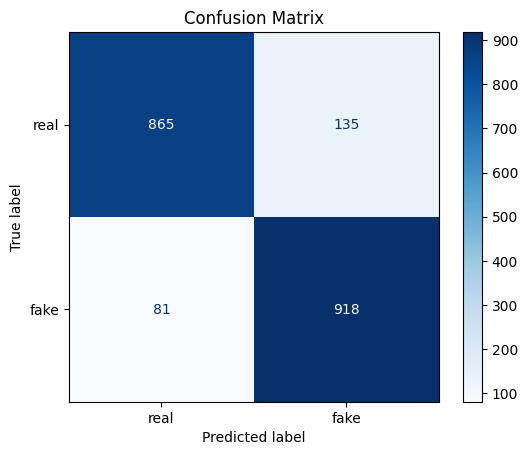

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Predict on Validation Set =====
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary class (0/1)

# True labels
true_labels = val_generator.classes

# ===== Classification Report =====
print("\n Classification Report:")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=val_generator.class_indices.keys()
))

# ===== Confusion Matrix =====
print("\n Confusion Matrix:")
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step


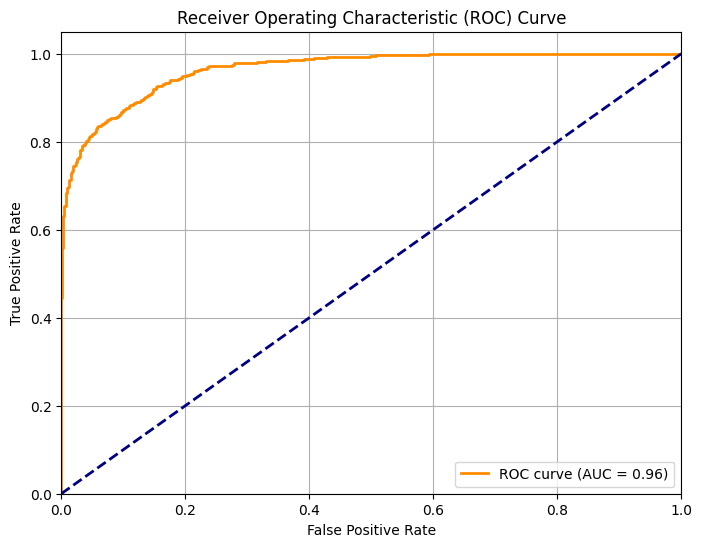

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities (already done)
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)

# True labels
true_labels = val_generator.classes

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()